In [11]:
from dataset.climatenet import ClimateDataset
from torch.utils.data import DataLoader
from functools import partial
from climatesam import ClimateSAM
from train import worker_init_fn
from train_util import batch_to_cuda
import torch
import os 
from evaluator import StreamSegMetrics
from tqdm import tqdm
import matplotlib.pyplot as plt

# Directory and file paths
config_file = 'input_config_test'  # config file path
exp_dir = './exp'  # The directory to save the best checkpoint file
data_dir = '/home/aiworker2/thang/climateNet'  # The directory that the datasets are placed

# Data loading parameters
num_workers = None  # Will be set to 1 for one-shot and 4 for 16- and full-shot
train_bs = 16  # Batch size for training dataloader (will be 1 for one-shot and 4 for 16- and full-shot)
val_bs = 4  # Batch size for validation dataloader (will be 1 for one-shot and 4 for 16- and full-shot)
shot_num = None  # Number of shots (1, 16, or None for full-shot)

# Model parameters
sam_type = 'vit_l'  # Backbone SAM model type (vit_b, vit_l, vit_h)
image_encoder_mlp_ratio = 0.5  # MLP ratio for the image encoder

# Training parameters
max_epoch_num = 1  # Maximum number of training epochs
lr = 1e-3  # Learning rate
weight_decay = 1e-4  # Weight decay
valid_per_epochs = 1  # Validation frequency in epochs
phase = 1  # Training phase (1-4)

# Loss function parameters
bce_weight_ar = 10  # Weight for BCE loss for AR
bce_weight_tc = 200  # Weight for BCE loss for TC
gamma_ar = 2  # Gamma for Focal loss for AR
gamma_tc = 2  # Gamma for Focal loss for TC
alpha_ar = 0.9  # Alpha for Focal loss for AR
alpha_tc = 0.98  # Alpha for Focal loss for TC

# Logging and debugging
wandb = False  # Enable Weights & Biases logging
project_name = "climate-sam"  # W&B project name
run_name = None  # W&B run name
debugging = False  # Enable debugging mode

# Model loading
load_pretrained = True  # Load pretrained model
pretrained_name = None  # Name of pretrained model to load
save_model = False  # Save the best model
sampler = None

In [12]:
device = torch.device(f"cuda:{0}")
torch.cuda.set_device(device)
train_dataset = ClimateDataset(
        data_dir=data_dir, train_flag=True, transforms=None
    )
val_dataset = ClimateDataset(data_dir=data_dir, train_flag=False)

train_dataloader = DataLoader(
        dataset=train_dataset, batch_size=train_bs, shuffle=None is None, num_workers=1,
        sampler=sampler, drop_last=False, collate_fn=train_dataset.collate_fn,
        worker_init_fn=partial(worker_init_fn, base_seed=3407))

val_dataloader = DataLoader(
    dataset=val_dataset, batch_size=val_bs, shuffle=False, num_workers=1,
    drop_last=False, collate_fn=val_dataset.collate_fn)
model = ClimateSAM(model_type=sam_type, mlp_ratio=image_encoder_mlp_ratio).to(device=device)
    

Loading mean/std from /home/aiworker2/thang/climateNet/mean_std.npy
AR Ratio (negative/positive): 16.982505712876822, TC Ratio: 257.2420611525207


In [13]:
image_encoder_path = os.path.join(exp_dir, f"phase_1_weights.pth")
phase_1_checkpoint = torch.load(image_encoder_path, map_location=device)
print(f"Pretrained weights from phase 1 loaded from {image_encoder_path}")
model.image_encoder.load_state_dict(phase_1_checkpoint['image_encoder'])
print(f"Image encoder weights loaded from {image_encoder_path}")
model.mask_decoder.load_state_dict(phase_1_checkpoint['mask_decoder'])
print(f"Mask decoder weights loaded from {image_encoder_path}")
            

Pretrained weights from phase 1 loaded from ./exp/phase_1_weights.pth
Image encoder weights loaded from ./exp/phase_1_weights.pth
Mask decoder weights loaded from ./exp/phase_1_weights.pth


In [14]:
ar_metrics = StreamSegMetrics(class_names=['Background', 'Foreground'])
tc_metrics = StreamSegMetrics(class_names=['Background', 'Foreground'])

In [15]:
model.eval()
valid_pbar = tqdm(total=len(val_dataloader), desc='valid', leave=False)
for val_step, batch in enumerate(val_dataloader):
    batch = batch_to_cuda(batch, device)
    val_model = model
    with torch.no_grad():
        input = batch['input']
        ar_bbox_prompts = batch['ar_bbox_prompts']
        tc_bbox_prompts = batch['tc_bbox_prompts']
        
        tc_masks, ar_masks, images = val_model(input,
                            # ar_point_prompts = batch['ar_point_prompts'],
                            # tc_point_prompts = batch['tc_point_prompts'], 
                            ar_bbox_prompts =ar_bbox_prompts, 
                            tc_bbox_prompts=tc_bbox_prompts,
                            )
        
        
        gt_masks = batch['gt_mask']
        tc_object_masks = batch['tc_object_masks']
        ar_object_masks = batch['ar_object_masks']
        

        
        break

In [16]:
for i, mask in enumerate(tc_masks):
    print(f"tc {i}", mask.shape)
for i, mask in enumerate(ar_masks):
    print(f"ar {i}", mask.shape)
for i, mask in enumerate(gt_masks):
    print(f"gt {i}", mask.shape)
for i, mask in enumerate(tc_object_masks):
    print(f"tc_object {i}", mask.shape if mask is not None else "None")
for i, mask in enumerate(ar_object_masks):
    print(f"ar_object {i}", mask.shape if mask is not None else "None")

    

tc 0 torch.Size([1, 1, 768, 1152])
tc 1 torch.Size([1, 1, 768, 1152])
tc 2 torch.Size([1, 1, 768, 1152])
tc 3 torch.Size([1, 1, 768, 1152])
ar 0 torch.Size([1, 1, 768, 1152])
ar 1 torch.Size([1, 1, 768, 1152])
ar 2 torch.Size([1, 1, 768, 1152])
ar 3 torch.Size([1, 1, 768, 1152])
gt 0 torch.Size([768, 1152])
gt 1 torch.Size([768, 1152])
gt 2 torch.Size([768, 1152])
gt 3 torch.Size([768, 1152])
tc_object 0 torch.Size([3, 1, 768, 1152])
tc_object 1 None
tc_object 2 torch.Size([1, 1, 768, 1152])
tc_object 3 None
ar_object 0 torch.Size([7, 1, 768, 1152])
ar_object 1 torch.Size([10, 1, 768, 1152])
ar_object 2 torch.Size([10, 1, 768, 1152])
ar_object 3 torch.Size([6, 1, 768, 1152])


In [17]:
for i, mask in enumerate(images):
    print(f"image {i}", mask.shape)
for i, mask in enumerate(ar_bbox_prompts):
    print(f"ar_bbox {i}", mask.shape if mask is not None else "None")
for i, mask in enumerate(tc_bbox_prompts):
    print(f"tc_bbox {i}", mask.shape if mask is not None else "None")
    

image 0 torch.Size([3, 1024, 1024])
image 1 torch.Size([3, 1024, 1024])
image 2 torch.Size([3, 1024, 1024])
image 3 torch.Size([3, 1024, 1024])
ar_bbox 0 None
ar_bbox 1 None
ar_bbox 2 torch.Size([10, 1, 4])
ar_bbox 3 torch.Size([6, 1, 4])
tc_bbox 0 None
tc_bbox 1 None
tc_bbox 2 torch.Size([1, 1, 4])
tc_bbox 3 None


In [18]:
def plot_mask(mask):
    """
    Plot a mask tensor.

    Parameters:
      mask: torch.Tensor, expected shape [batch, channel, height, width]
      i: int, index of the mask
      mask_type: str, used in the title and print statement
    """
    mask_cpu = mask.cpu().detach().numpy()
    plt.figure()
    plt.imshow(mask_cpu, cmap='gray')
    plt.colorbar()
    plt.show()

torch.Size([1, 768, 1152])


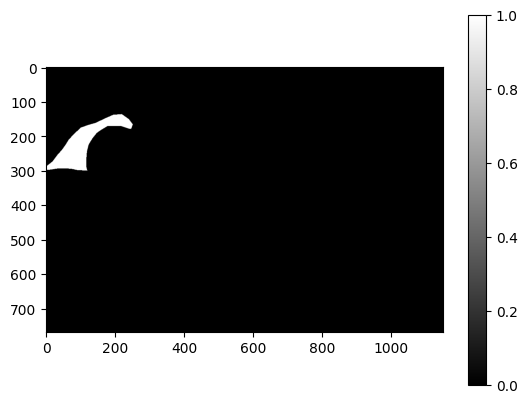

torch.Size([1, 768, 1152])


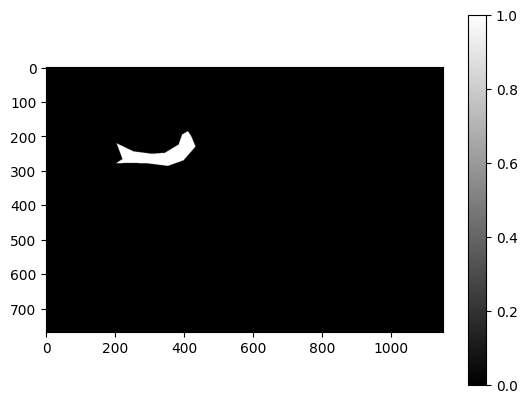

torch.Size([1, 768, 1152])


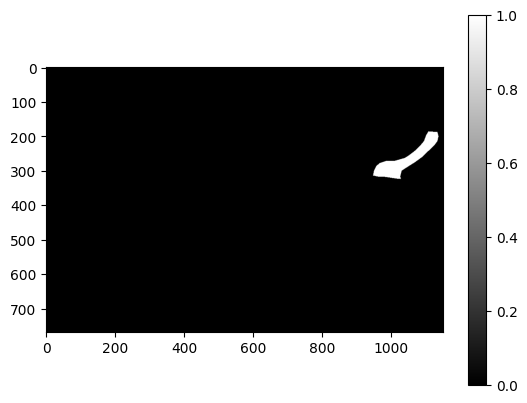

torch.Size([1, 768, 1152])


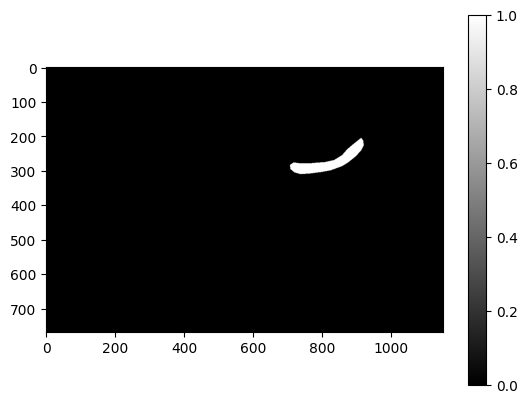

torch.Size([1, 768, 1152])


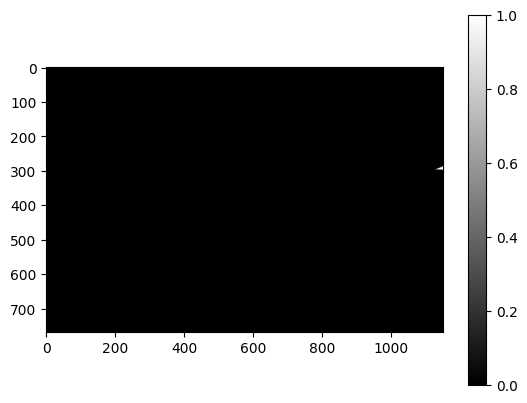

torch.Size([1, 768, 1152])


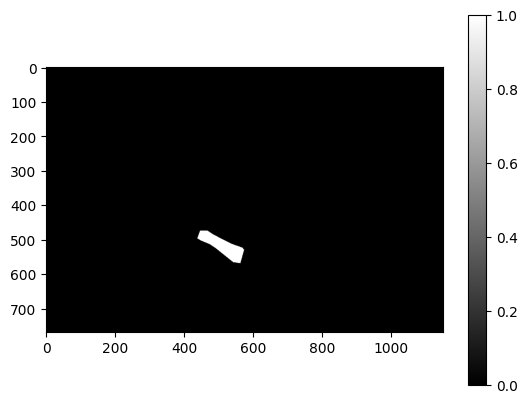

torch.Size([1, 768, 1152])


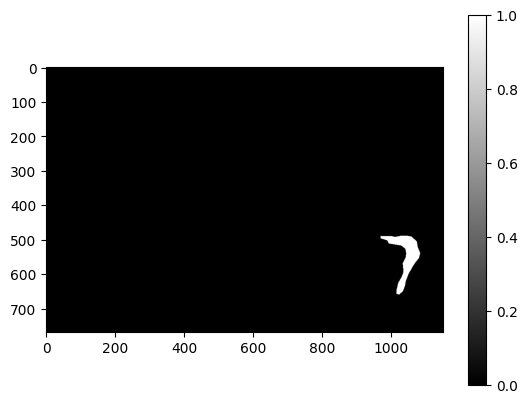

In [19]:
for mask in ar_object_masks[0]:
    print(mask.shape)
    if mask is not None:
        plot_mask(mask.squeeze())
    else:
        print("None")

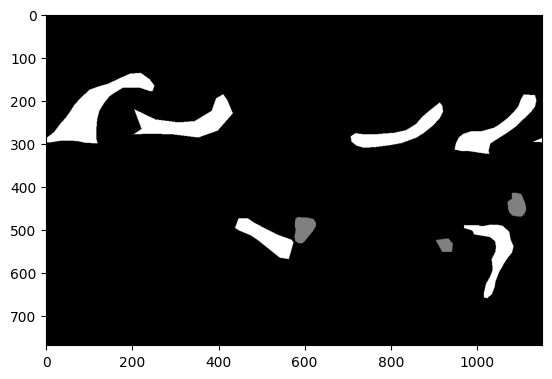

In [20]:
plt.figure()
plt.imshow(gt_masks[0], cmap='gray')